# Tutorial #1 - Preprocessing, Calibration, Augmentation, and Deconvolution

## Load the PyEEM library and display version

In [1]:
import pyeem
print(pyeem.__version__)

0.1.0


## Check out the supported instruments

In [2]:
pyeem.instruments.supported

name
manufacturer supported_models              
Agilent      Cary 4E                cary_4e
             Cary Eclipse      cary_eclipse
Horiba       Aqualog-880-C          aqualog
             SPEX Fluorolog-3     fluorolog

## Check out the demo datasets

In [3]:
demos_df = pyeem.datasets.demos
display(demos_df)

print("Dataset description for the Rutherford et al. demo:")
print(demos_df[
    demos_df["demo_name"] == "rutherford"
]["description"].item())

,demo_name,description,citation,DOI,absorbance_instrument,water_raman_instrument,EEM_instrument
0,rutherford,Excitation Emission Matrix (EEM) fluorescence ...,"Rutherford, Jay W., et al. ""Excitation emissio...",10.1016/j.atmosenv.2019.117065,Aqualog,None,Aqualog
1,drEEM,The demo dataset contains measurements made du...,"Murphy, Kathleen R., et al. ""Fluorescence spec...",10.1039/c3ay41160e,Cary 4E,Fluorolog,Fluorolog


Dataset description for the Rutherford et al. demo:
Excitation Emission Matrix (EEM) fluorescence spectra used for combustion generated particulate matter source identification using a neural network.


## Download the Rutherford et al. demo dataset from S3
- Please note that this step requires an internet connection because the data is downloaded from an AWS S3 bucket.

In [4]:
demo_data_dir = pyeem.datasets.download_demo(
    "demo_data",
    demo_name="rutherford"
)

Download Demo Dataset from S3: 100%|██████████| 239/239 [01:27<00:00,  2.73it/s]


## Load the dataset

In [5]:
calibration_sources = {
    "cigarette": "ug/ml",
    "diesel": "ug/ml",
    "wood_smoke": "ug/ml"
}
dataset = pyeem.datasets.Dataset(
    data_dir=demo_data_dir,
    raman_instrument=None,
    absorbance_instrument="aqualog",
    eem_instrument="aqualog",
    calibration_sources=calibration_sources,
)

## Let's checkout the metadata
- The metadata contains information about collected sample sets which are composed of a few different scan types.

In [6]:
display(dataset.meta_df.head())

datetime_utc         filename collected_by  \
sample_set scan_type                                                      
1          blank_eem  2020-07-01 10:29:05   blank_eem1.csv           JR   
           sample_eem 2020-07-01 10:29:06  sample_eem1.csv           JR   
           sample_eem 2020-07-01 10:29:07  sample_eem2.csv           JR   
           sample_eem 2020-07-01 10:29:08  sample_eem3.csv           JR   
           sample_eem 2020-07-01 10:29:09  sample_eem4.csv           JR   

                                             description  \
sample_set scan_type                                       
1          blank_eem            Spectroscopy Grade Blank   
           sample_eem                            Diesel1   
           sample_eem                            Diesel2   
           sample_eem                            Diesel3   
           sample_eem  Cigarette from Cookstove Lab Hood   

                                                                comments  \
sample_set scan_type                                                       
1          blank_eem   Raman units collected with 1 pixel binning so ...   
           sample_eem  Raman units collected with 1 pixel binning so ...   
           sample_eem  Raman units collected with 1 pixel binning so ...   
           sample_eem  Raman units collected with 1 pixel binning so ...   
           sample_eem  Raman units collected with 1 pixel binning so ...   

                       dilution  Raman_Area  cigarette  diesel  wood_smoke  \
sample_set scan_type                                                         
1          blank_eem        1.0   2040.3794       0.00     0.0         0.0   
           sample_eem       1.0   2040.3794       0.00     5.0         0.0   
           sample_eem       1.0   2040.3794       0.00     5.0         0.0   
           sample_eem       1.0   2040.3794       0.00     5.0         0.0   
           sample_eem       1.0   2040.3794       0.77     0.0         0.0   

                       calibration_sample  prototypical_sample  test_sample  \
sample_set scan_type                                                          
1          blank_eem                False                False        False   
           sample_eem                True                False         True   
           sample_eem                True                 True        False   
           sample_eem                True                False         True   
           sample_eem                True                False         True   

                      original_date  \
sample_set scan_type                  
1          blank_eem     2016-11-30   
           sample_eem    2016-11-30   
           sample_eem    2016-11-30   
           sample_eem    2016-11-30   
           sample_eem    2016-11-30   

                                                                filepath  \
sample_set scan_type                                                       
1          blank_eem   /home/roboat/Documents/roboat/PyEEM/docs/sourc...   
           sample_eem  /home/roboat/Documents/roboat/PyEEM/docs/sourc...   
           sample_eem  /home/roboat/Documents/roboat/PyEEM/docs/sourc...   
           sample_eem  /home/roboat/Documents/roboat/PyEEM/docs/sourc...   
           sample_eem  /home/roboat/Documents/roboat/PyEEM/docs/sourc...   

                              name                       hdf_path  
sample_set scan_type                                               
1          blank_eem    blank_eem1   raw_sample_sets/1/blank_eem1  
           sample_eem  sample_eem1  raw_sample_sets/1/sample_eem1  
           sample_eem  sample_eem2  raw_sample_sets/1/sample_eem2  
           sample_eem  sample_eem3  raw_sample_sets/1/sample_eem3  
           sample_eem  sample_eem4  raw_sample_sets/1/sample_eem4

## Checkout the metadata summary information

In [7]:
dataset.metadata_summary_info()

,Start datetime (UTC),End datetime (UTC),Number of sample sets,Number of blank EEMs,Number of sample EEMs,Number of water raman scans,Number of absorbance scans
0,2020-07-01 10:29:05,2020-07-01 10:33:01,14,20,107,0,107


## Create a preprocessing routine
- The demo dataset contains raw scans, in order to analyze and interpret this data, we must first apply several preprocessing steps.

In [8]:
routine_df = pyeem.preprocessing.create_routine(
    crop = True,
    discrete_wavelengths = False,
    gaussian_smoothing = False,
    blank_subtraction = True,
    inner_filter_effect = True,
    raman_normalization = True,
    scatter_removal = True,
    dilution = False,
)

display(routine_df)

,step_name,hdf_path
step_order,,
0,raw,raw_sample_sets/
1,crop,preprocessing/filters/crop
2,blank_subtraction,preprocessing/corrections/blank_subtraction
3,inner_filter_effect,preprocessing/corrections/inner_filter_effect
4,raman_normalization,preprocessing/corrections/raman_normalization
5,scatter_removal,preprocessing/corrections/scatter_removal
6,complete,preprocessing/complete/


## Execute the preprocessing routine
- Each preprocessing step has certain knobs and dials you can tune to have them run to your liking. It is worth checking the documentation to learn more about these customizations.
- Please note that depending on the steps and settings you've chosen as well as your dataset's size, the time it takes for this step to complete will vary.

In [9]:
crop_dimensions = {
    "emission_bounds": (246, 573),
    "excitation_bounds": (224, float("inf"))
}
routine_results_df = pyeem.preprocessing.perform_routine(
    dataset,
    routine_df,
    crop_dims=crop_dimensions,
    raman_source_type = "metadata",
    fill="interp",
    progress_bar=True
)

display(routine_results_df)

Preprocessing scan sets: 100%|██████████| 14/14 [01:15<00:00,  5.39s/it]


step_completed  \
sample_set scan_type  name        step_name                            
1          blank_eem  blank_eem1  raw                           True   
                                  crop                          True   
           sample_eem sample_eem1 raw                           True   
                                  crop                          True   
                                  blank_subtraction             True   
...                                                              ...   
16         sample_eem sample_eem1 raman_normalization           True   
                                  scatter_removal               True   
                                  complete                      True   
17         blank_eem  blank_eem1  raw                           True   
                                  crop                          True   

                                                      step_exception  \
sample_set scan_type  name        step_name                            
1          blank_eem  blank_eem1  raw                           None   
                                  crop                          None   
           sample_eem sample_eem1 raw                           None   
                                  crop                          None   
                                  blank_subtraction             None   
...                                                              ...   
16         sample_eem sample_eem1 raman_normalization           None   
                                  scatter_removal               None   
                                  complete                      None   
17         blank_eem  blank_eem1  raw                           None   
                                  crop                          None   

                                                                                                hdf_path  \
sample_set scan_type  name        step_name                                                                
1          blank_eem  blank_eem1  raw                                       raw_sample_sets/1/blank_eem1   
                                  crop                           preprocessing/filters/crop/1/blank_eem1   
           sample_eem sample_eem1 raw                                      raw_sample_sets/1/sample_eem1   
                                  crop                          preprocessing/filters/crop/1/sample_eem1   
                                  blank_subtraction    preprocessing/corrections/blank_subtraction/1/...   
...                                                                                                  ...   
16         sample_eem sample_eem1 raman_normalization  preprocessing/corrections/raman_normalization/...   
                                  scatter_removal      preprocessing/corrections/scatter_removal/16/s...   
                                  complete                         preprocessing/complete/16/sample_eem1   
17         blank_eem  blank_eem1  raw                                      raw_sample_sets/17/blank_eem1   
                                  crop                          preprocessing/filters/crop/17/blank_eem1   

                                                               units  
sample_set scan_type  name        step_name                           
1          blank_eem  blank_eem1  raw                  Intensity, AU  
                                  crop                 Intensity, AU  
           sample_eem sample_eem1 raw                  Intensity, AU  
                                  crop                 Intensity, AU  
                                  blank_subtraction    Intensity, AU  
...                                                              ...  
16         sample_eem sample_eem1 raman_normalization  Intensity, RU  
                                  scatter_removal      Intensity, RU  
                                  complete             Intensity,

## Check to see if any of the steps failed to complete
- If you are using a demo dataset, you should see an empty dataframe.

In [10]:
display(routine_results_df[
    routine_results_df["step_exception"].notna()
])

,,,,step_completed,step_exception,hdf_path,units
sample_set,scan_type,name,step_name,,,,


## Visualize the preprocessing steps for a single sample

AttributeError: module 'matplotlib.axes._subplots' has no attribute 'AxesSubplot'

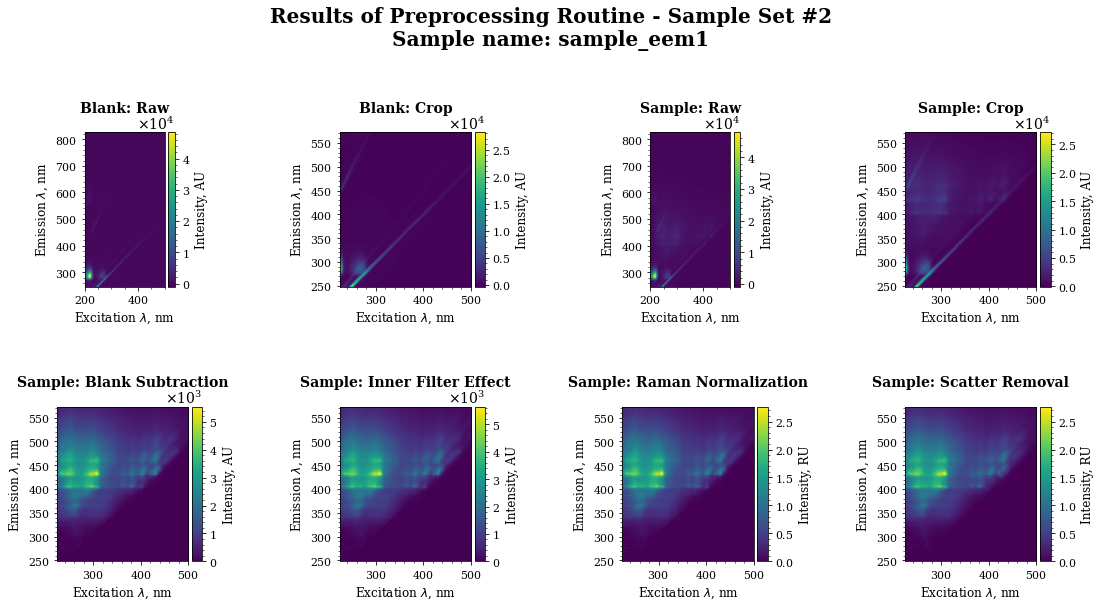

In [424]:
import matplotlib.pyplot as plt
import matplotlib

sample_set = 2
sample_name = "sample_eem1"
axes = pyeem.plots.plot_preprocessing(
    dataset,
    routine_results_df,
    sample_set=sample_set,
    sample_name=sample_name,
    plot_type="imshow",
)
assert isinstance(axes, list)
for ax in axes:
    assert isinstance(ax, matplotlib.axes._subplots.AxesSubplot)
plt.show()

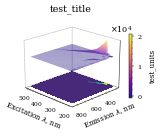

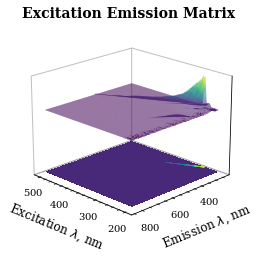

In [196]:
import pandas as pd
import matplotlib
hdf_path = dataset.meta_df.loc[1, "sample_eem"]["hdf_path"].iloc[0]
eem_df = pd.read_hdf(dataset.hdf, key=hdf_path)

fig_kws={"dpi": 42}
intensity_units = "test_units"
kwargs = {"title": "test_title",
          "title_fontsize": 16,
          "title_fontweight": "light",
          "surface_plot_kws":{"cmap":"plasma", "alpha":0.42},
         }
ax = pyeem.plots.eem_plot(
    eem_df,
    plot_type="surface_contour",
    intensity_units=intensity_units,
    plot_kws=plot_kws,
    fig_kws=fig_kws,
    **kwargs
)

assert kwargs["surface_plot_kws"]["alpha"] == ax.get_alpha()
assert kwargs["surface_plot_kws"]["cmap"] == ax.get_cmap().name

assert fig_kws["dpi"] == plt.gcf().properties()["dpi"]

assert kwargs["title"] == ax.axes.get_title()
assert kwargs["title_fontsize"] == ax.axes.title.get_fontsize()
assert kwargs["title_fontweight"] == ax.axes.title.get_fontweight()

assert intensity_units == ax.colorbar.ax.get_ylabel()
assert ax.colorbar is not None



include_cbar = False
ax = pyeem.plots.eem_plot(
    eem_df,
    plot_type="surface_contour",
    include_cbar=include_cbar,
)
assert ax.colorbar is None

## Load the calibration information

In [425]:
cal_df = pyeem.preprocessing.calibration(
    dataset,
    routine_results_df
)
display(cal_df)

concentration  \
source     source_units intensity_units measurement_units        slope       intercept    r_squared                  
cigarette  ug/ml        Intensity, RU   Integrated Intensity, RU 2532.409217 -620.162018  0.929928            0.77   
                                                                                          0.929928            5.00   
                                                                                          0.929928            5.00   
                                                                                          0.929928            5.00   
                                                                                          0.929928            5.00   
...                                                                                                            ...   
wood_smoke ug/ml        Intensity, RU   Integrated Intensity, RU 4860.709872 -1572.345781 0.460195            0.50   
                                                                                          0.460195            0.50   
                                                                                          0.460195            2.00   
                                                                                          0.460195            1.00   
                                                                                          0.460195            5.00   

                                                                                                     integrated_intensity  \
source     source_units intensity_units measurement_units        slope       intercept    r_squared                         
cigarette  ug/ml        Intensity, RU   Integrated Intensity, RU 2532.409217 -620.162018  0.929928            1605.582491   
                                                                                          0.929928           11369.642711   
                                                                                          0.929928            9937.219073   
                                                                                          0.929928           14786.022223   
                                                                                          0.929928           14005.964492   
...                                                                                                                   ...   
wood_smoke ug/ml        Intensity, RU   Integrated Intensity, RU 4860.709872 -1572.345781 0.460195            2654.533537   
                                                                                          0.460195             856.330949   
                                                                                          0.460195            3413.400549   
                                                                                          0.460195            1719.608567   
                                                                                          0.460195           23200.187472   

                                                                                                     prototypical_sample  \
source     source_units intensity_units measurement_units        slope       intercept    r_squared                        
cigarette  ug/ml        Intensity, RU   Integrated Intensity, RU 2532.409217 -620.162018  0.929928                 False   
                                                                                          0.929928                  True   
                                                                                          0.929928                  True   
                                                                                          0.929928                 False   
                                                                                          0.929928                 False   
...                                                                     

## Checkout the calibration summary information

In [428]:
cal_summary_df = pyeem.preprocessing.calibration_summary_info(cal_df)
display(cal_summary_df)
assert cal_summary_df["source"].values.tolist() == list(dataset.calibration_sources.keys())

,source,source_units,intensity_units,measurement_units,slope,intercept,r_squared,Number of Samples,Min. Concentration,Max. Concentration
0,cigarette,ug/ml,"Intensity, RU","Integrated Intensity, RU",2532.409217,-620.162018,0.929928,26,0.2,5.0
1,cigarette,ug/ml,"Intensity, RU","Integrated Intensity, RU",2532.409217,-620.162018,0.929928,26,0.2,5.0
2,cigarette,ug/ml,"Intensity, RU","Integrated Intensity, RU",2532.409217,-620.162018,0.929928,26,0.2,5.0


AssertionError: 

## Plot the calibration curves

Cigarette Fluorescence Calibration Curve
for the Horiba Aqualog
Cigarette Concentration, ug/ml
Integrated Intensity, RU
[Text(0, 0, 'y =  2532 x - 620.2\n$R^2=0.93$'), Text(0, 0, 'non-proto. sample'), Text(0, 0, 'proto. sample')]


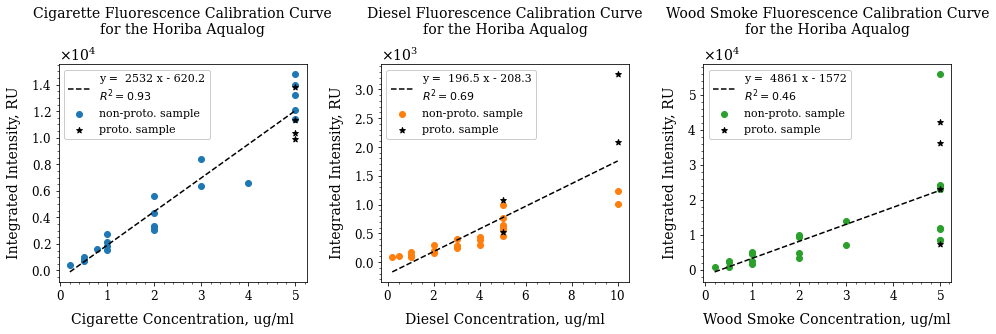

In [338]:
import numpy as np

axes = pyeem.plots.plot_calibration_curves(dataset, cal_df)

cal_sources_list = cal_df.index.get_level_values("source").unique().tolist()
assert isinstance(axes, np.ndarray)
assert len(axes.flatten()) == len(cal_sources_list)

for ax in axes.flatten():
    assert isinstance(ax, matplotlib.axes.Axes)
    print(ax.get_title())
    # assert title
    print(ax.get_xlabel())
    # assert xlabel
    print(ax.get_ylabel())
    # assert ylabel
    print(ax.get_legend().texts)
    # assert function and r^2
    break

#plt.show()

## Create prototypical spectra and then plot them

,proto_conc,source_units,intensity_units,hdf_path
source,,,,
cigarette,5.0,ug/ml,"Intensity, RU",augmentation/prototypical/cigarette
diesel,7.5,ug/ml,"Intensity, RU",augmentation/prototypical/diesel
wood_smoke,5.0,ug/ml,"Intensity, RU",augmentation/prototypical/wood_smoke


[<AxesSubplot:title={'center':'Prototypical Spectrum: Cigarette\nConcentration: 5.0 ug/ml'}, xlabel='Excitation $\\lambda$, nm', ylabel='Emission $\\lambda$, nm'>, <AxesSubplot:title={'center':'Prototypical Spectrum: Diesel\nConcentration: 7.5 ug/ml'}, xlabel='Excitation $\\lambda$, nm', ylabel='Emission $\\lambda$, nm'>, <AxesSubplot:title={'center':'Prototypical Spectrum: Wood_Smoke\nConcentration: 5.0 ug/ml'}, xlabel='Excitation $\\lambda$, nm', ylabel='Emission $\\lambda$, nm'>, <AxesSubplot:>]
<class 'list'>
<class 'matplotlib.axes._subplots.AxesSubplot'>
<class 'matplotlib.axes._subplots.AxesSubplot'>
<class 'matplotlib.axes._subplots.AxesSubplot'>
<class 'matplotlib.axes._subplots.AxesSubplot'>


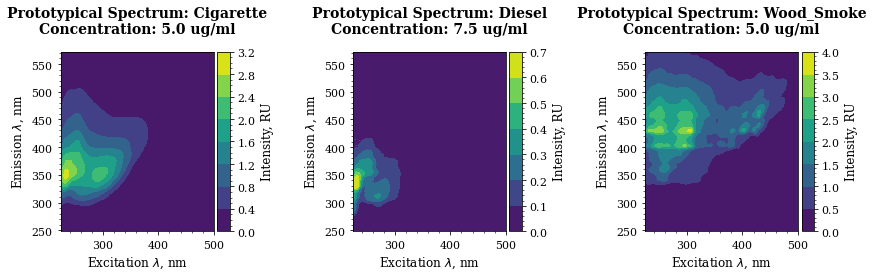

In [421]:
proto_results_df = pyeem.augmentation.create_prototypical_spectra(
    dataset,
    cal_df
)
display(proto_results_df)

axes = pyeem.plots.plot_prototypical_spectra(
    dataset,
    proto_results_df,
    plot_type="contour"
)
print(axes)
print(type(axes))
for ax in axes:
    print(type(ax))
plt.show()

## Augmented Spectra - Single Sources
### Create augmented single source spectra by scaling each prototypical spectrum across a range of concentrations

In [341]:
ss_results_df = pyeem.augmentation.create_single_source_spectra(
    dataset,
    cal_df,
    conc_range=(0, 5),
    num_spectra=10
)
display(ss_results_df)

100%|██████████| 3/3 [00:00<00:00,  7.38it/s]


cigarette  \
source     source_units intensity_units hdf_path                                            
cigarette  ug/ml        Intensity, RU   augmentation/single_sources/cigarette    0.000000   
                                        augmentation/single_sources/cigarette    0.555556   
                                        augmentation/single_sources/cigarette    1.111111   
                                        augmentation/single_sources/cigarette    1.666667   
                                        augmentation/single_sources/cigarette    2.222222   
                                        augmentation/single_sources/cigarette    2.777778   
                                        augmentation/single_sources/cigarette    3.333333   
                                        augmentation/single_sources/cigarette    3.888889   
                                        augmentation/single_sources/cigarette    4.444444   
                                        augmentation/single_sources/cigarette    5.000000   
diesel     ug/ml        Intensity, RU   augmentation/single_sources/diesel       0.000000   
                                        augmentation/single_sources/diesel       0.000000   
                                        augmentation/single_sources/diesel       0.000000   
                                        augmentation/single_sources/diesel       0.000000   
                                        augmentation/single_sources/diesel       0.000000   
                                        augmentation/single_sources/diesel       0.000000   
                                        augmentation/single_sources/diesel       0.000000   
                                        augmentation/single_sources/diesel       0.000000   
                                        augmentation/single_sources/diesel       0.000000   
                                        augmentation/single_sources/diesel       0.000000   
wood_smoke ug/ml        Intensity, RU   augmentation/single_sources/wood_smoke   0.000000   
                                        augmentation/single_sources/wood_smoke   0.000000   
                                        augmentation/single_sources/wood_smoke   0.000000   
                                        augmentation/single_sources/wood_smoke   0.000000   
                                        augmentation/single_sources/wood_smoke   0.000000   
                                        augmentation/single_sources/wood_smoke   0.000000   
                                        augmentation/single_sources/wood_smoke   0.000000   
                                        augmentation/single_sources/wood_smoke   0.000000   
                                        augmentation/single_sources/wood_smoke   0.000000   
                                        augmentation/single_sources/wood_smoke   0.000000   

                                                                                  diesel  \
source     source_units intensity_units hdf_path                                           
cigarette  ug/ml        Intensity, RU   augmentation/single_sources/cigarette   0.000000   
                                        augmentation/single_sources/cigarette   0.000000   
                                        augmentation/single_sources/cigarette   0.000000   
                                        augmentation/single_sources/cigarette   0.000000   
                                        augmentation/single_sources/cigarette   0.000000   
                                        augmentation/single_sources/cigarette   0.000000   
                                        augmentation/single_sources/cigarette   0.000000   
                                        augmentation/single_sources/cigarette   0.000000   
                                        augmentation/single_sources/cigarette   0.000000   
                                        augmentation/single_sources/cigarette   0.000000   

## Plot the augmented single source spectra

In [ ]:
from IPython.display import HTML
%matplotlib inline

source = "wood_smoke"
anim = pyeem.plots.single_source_animation(
    dataset,
    ss_results_df,
    source=source,
    plot_type="imshow",
    fig_kws={"dpi": 120},
    animate_kws={"interval": 100, "blit": True},
    surface_plot_kws={"rstride":10,"cstride":10}
)
HTML(anim.to_html5_video())

In [ ]:
source = "diesel"
anim = pyeem.plots.single_source_animation(
    dataset,
    ss_results_df,
    source=source,
    plot_type="contour",
    fig_kws={"dpi": 120},
    animate_kws={"interval": 100, "blit": True},
)
HTML(anim.to_html5_video())

In [ ]:
source = "cigarette"
anim = pyeem.plots.single_source_animation(
    dataset,
    ss_results_df,
    source=source,
    plot_type="contour",
    fig_kws={"dpi": 120},
    animate_kws={"interval": 100, "blit": True},
)
HTML(anim.to_html5_video())

## Augmented Spectra - Mixtures
### Create augmented mixture spectra by scaling and combining the prototypical spectra across a range of concentrations

In [342]:
mix_results_df = pyeem.augmentation.create_mixtures(
    dataset,
    cal_df,
    conc_range=(0.01, 6.3),
    num_steps=5
)

Creating Augmented Mixtures: 100%|██████████| 125/125 [00:02<00:00, 52.52it/s]


## Plot the augmented mixture spectra

In [ ]:
anim = pyeem.plots.mixture_animation(
    dataset,
    mix_results_df,
    plot_type="contour",
    fig_kws={"dpi": 120},
    animate_kws={"interval": 100, "blit": True},
    surface_plot_kws={"rstride":10,"cstride":10}
)
HTML(anim.to_html5_video())

In [343]:
rutherfordnet = pyeem.analysis.models.RutherfordNet()
rutherfordnet.model.summary()

Model: "rutherfordnet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 142, 139, 20)      520       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 47, 46, 20)        0         
_________________________________________________________________
dropout (Dropout)            (None, 47, 46, 20)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 46, 10)        20010     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 10)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 10)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 10)      

In [344]:
(x_train, y_train), (x_test, y_test) = rutherfordnet.prepare_data(
    dataset,
    ss_results_df,
    mix_results_df,
    routine_results_df
)

history = rutherfordnet.train(x_train, y_train)

Epoch 1/5
3/3 [==============================] - 1s 260ms/step - loss: 3.1612 - accuracy: 0.4026 - val_loss: 7.3282 - val_accuracy: 0.2564
Epoch 2/5
3/3 [==============================] - 1s 219ms/step - loss: 2.3754 - accuracy: 0.6234 - val_loss: 8.4301 - val_accuracy: 0.1923
Epoch 3/5
3/3 [==============================] - 1s 218ms/step - loss: 1.9741 - accuracy: 0.6883 - val_loss: 6.2851 - val_accuracy: 0.2564
Epoch 4/5
3/3 [==============================] - 1s 215ms/step - loss: 1.8874 - accuracy: 0.6883 - val_loss: 6.8835 - val_accuracy: 0.2308
Epoch 5/5
3/3 [==============================] - 1s 213ms/step - loss: 1.8691 - accuracy: 0.6623 - val_loss: 8.4921 - val_accuracy: 0.2436


In [355]:
predictions = rutherfordnet.model.predict(x_test)

,cigarette_measurement,diesel_measurement,wood_smoke_measurement,cigarette_prediction,diesel_prediction,wood_smoke_prediction
0,0.00,5.0,0.0,-0.054481,2.176773,0.142864
1,0.00,5.0,0.0,-0.041308,2.050683,0.100218
2,0.77,0.0,0.0,-0.137128,1.761821,0.295339
3,1.00,0.0,0.0,-0.213229,1.932085,0.499614
4,0.00,0.0,2.0,-0.454637,0.910900,1.315794
...,...,...,...,...,...,...
90,5.00,5.0,0.0,-0.628540,2.837070,2.226976
91,5.00,0.0,5.0,-0.922912,1.589084,3.491563
92,0.00,5.0,5.0,-0.807564,0.584755,2.757380
93,4.00,4.0,4.0,-0.867876,1.587083,3.083326


'\nfor source in dataset.calibration_sources:\n    x = pred_df[source].values\n    y = meas_df[source].values\n    #\n'

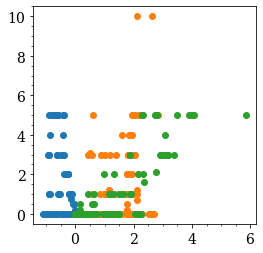

In [414]:
cal_sources = list(dataset.calibration_sources.keys())
meas_df = pd.DataFrame(y_test, columns=cal_sources)
meas_df = meas_df.add_suffix('_measurement')

pred_df = pd.DataFrame(predictions, columns=cal_sources)
pred_df = pred_df.add_suffix('_prediction')

joined = pd.concat([meas_df, pred_df], axis=1)
display(joined)

for source in cal_sources:
    y = joined[source + '_measurement']
    x = joined[source + "_prediction"]
    plt.scatter(x,y)

array([[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

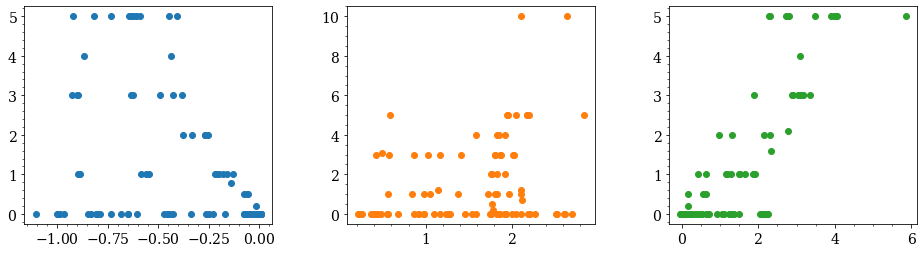

In [417]:
def _get_subplot_dims(n):
    """[summary]

    Args:
        n (int): [description]

    Returns:
        tuple of int: [description]
    """
    ncols = 4
    if n % ncols:
        nplots = n + (ncols - n % ncols)
    else:
        nplots = n

    nrows = int(nplots / ncols)
    return nrows, ncols

def plot_pred_curves(dataset, joined, subplots=False, fig_kws={}, **kwargs):
    colors = plt.rcParams["axes.prop_cycle"]()
    sources = dataset.calibration_sources

    nsources = len(sources)
    nrows, ncols = _get_subplot_dims(nsources)
    nplots = nrows * ncols

    default_fig_kws = dict(figsize=(ncols ** 2, nrows * ncols), squeeze=False)
    fig_kws = dict(default_fig_kws, **fig_kws)

    fig, axes = plt.subplots(1, nsources, **fig_kws)

    def _get_regression_metric(source_df, metric):
        return source_df.index.get_level_values(level=metric).unique().item()

    ax_idx = 0
    lines = []
    labels = []
    for source in sources:
        c = next(colors)["color"]
        y = joined[source + '_measurement']
        x = joined[source + "_prediction"]
        axes.flat[ax_idx].scatter(x, y, label="non-proto. sample", color=c)
        """
        source_df = cal_df.xs(source, level="source")
        source_units = _get_regression_metric(source_df, "source_units")
        measurement_units = _get_regression_metric(source_df, "measurement_units")
        slope = _get_regression_metric(source_df, "slope")
        y_intercept = _get_regression_metric(source_df, "intercept")
        r_squared = _get_regression_metric(source_df, "r_squared")

        cal_poly = np.poly1d([slope, y_intercept])

        proto_spectra_df = source_df[source_df["prototypical_sample"]]
        non_proto_spectra_df = source_df[~source_df["prototypical_sample"]]

        p_x = proto_spectra_df["concentration"].values
        p_y = proto_spectra_df["integrated_intensity"].values
        np_x = non_proto_spectra_df["concentration"].values
        np_y = non_proto_spectra_df["integrated_intensity"].values
        axes.flat[ax_idx].scatter(np_x, np_y, label="non-proto. sample", color=c)
        axes.flat[ax_idx].scatter(
            p_x, p_y, label="proto. sample", marker="*", color="black"
        )

        x = np.linspace(
            source_df["concentration"].min(), source_df["concentration"].max()
        )
        axes.flat[ax_idx].plot(
            x,
            cal_poly(x),
            label="y = %s\n$R^2=%.2f$" % (str(cal_poly).replace("\n", ""), r_squared),
            color="black",
            linestyle="--",
        )

        formatted_source_str = source.replace("_", " ").title()
        xlabel_str = "%s Concentration, %s" % (formatted_source_str, source_units)
        axes.flat[ax_idx].set_xlabel(xlabel_str, fontsize=14)
        axes.flat[ax_idx].set_ylabel(measurement_units, fontsize=14)
        axes.flat[ax_idx].tick_params(axis="both", which="major", labelsize=12)
        axes.flat[ax_idx].set_title(
            "%s Fluorescence Calibration Curve\nfor the %s %s"
            % (
                formatted_source_str,
                dataset.instruments_df.eem.item().manufacturer,
                dataset.instruments_df.eem.item().name.replace("_", " ").title(),
            ),
            pad=30,
            fontsize=14,
        )
        ax_line, ax_label = axes.flat[ax_idx].get_legend_handles_labels()
        lines.extend(ax_line)
        labels.extend(ax_label)
        axes.flat[ax_idx].legend(loc="upper left", fontsize=11)
        """
        ax_idx += 1

    hspace = kwargs.get("subplot_hspace", 0)
    wspace = kwargs.get("subplot_wspace", 0.3)
    plt.subplots_adjust(wspace=wspace, hspace=hspace)
    return axes

plot_pred_curves(dataset, joined)

In [418]:
display(cal_df)

concentration  \
source     source_units intensity_units measurement_units        slope       intercept    r_squared                  
cigarette  ug/ml        Intensity, RU   Integrated Intensity, RU 2532.409217 -620.162018  0.929928            0.77   
                                                                                          0.929928            5.00   
                                                                                          0.929928            5.00   
                                                                                          0.929928            5.00   
                                                                                          0.929928            5.00   
...                                                                                                            ...   
wood_smoke ug/ml        Intensity, RU   Integrated Intensity, RU 4860.709872 -1572.345781 0.460195            0.50   
                                                                                          0.460195            0.50   
                                                                                          0.460195            2.00   
                                                                                          0.460195            1.00   
                                                                                          0.460195            5.00   

                                                                                                     integrated_intensity  \
source     source_units intensity_units measurement_units        slope       intercept    r_squared                         
cigarette  ug/ml        Intensity, RU   Integrated Intensity, RU 2532.409217 -620.162018  0.929928            1605.582491   
                                                                                          0.929928           11369.642711   
                                                                                          0.929928            9937.219073   
                                                                                          0.929928           14786.022223   
                                                                                          0.929928           14005.964492   
...                                                                                                                   ...   
wood_smoke ug/ml        Intensity, RU   Integrated Intensity, RU 4860.709872 -1572.345781 0.460195            2654.533537   
                                                                                          0.460195             856.330949   
                                                                                          0.460195            3413.400549   
                                                                                          0.460195            1719.608567   
                                                                                          0.460195           23200.187472   

                                                                                                     prototypical_sample  \
source     source_units intensity_units measurement_units        slope       intercept    r_squared                        
cigarette  ug/ml        Intensity, RU   Integrated Intensity, RU 2532.409217 -620.162018  0.929928                 False   
                                                                                          0.929928                  True   
                                                                                          0.929928                  True   
                                                                                          0.929928                 False   
                                                                                          0.929928                 False   
...                                                                     